<a href="https://colab.research.google.com/github/eugeneyan/visualizing-finetunes/blob/main/3_ft_usb_then_fib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat May 11 21:49:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   70C    P0              23W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pip install -q transformers==4.37.2 accelerate bitsandbytes datasets peft watermark

In [ ]:
%load_ext watermark
%watermark --conda -p torch,transformers,peft,datasets,sklearn

torch       : 2.2.1+cu121
transformers: 4.37.2
peft        : 0.10.0
datasets    : 2.19.1
sklearn     : 1.2.2

conda environment: n/a



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import transformers
import time
import logging
import warnings
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Trainer,
    BartForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    IntervalStrategy,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from typing import Dict, Optional, List
from sklearn.metrics import (average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.exceptions import UndefinedMetricWarning

In [ ]:
# Set up logger
logger = logging.getLogger('3-ft-usb-then-fib')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

logger.info('Running notebook to finetune USB followed by FIB')

2024-05-11 21:50:11 - INFO - Running notebook to finetune USB followed by FIB


In [ ]:
# Suppress undefined metric warning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.manual_seed(1368)

## Define model and tokenizer
- Note: Entailment = 2, Neutral = 1, Contradiction = 0
- https://huggingface.co/valhalla/distilbart-mnli-12-1

In [ ]:
# Define model
model_id = 'valhalla/distilbart-mnli-12-1'
lora_model_id = 'lora-distilbart-mnli-12-1'

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Load FIB data

In [ ]:
# Test loading into dataset
fib_files = {'train': '/content/drive/My Drive/fib-train.csv',
             'val': '/content/drive/My Drive/fib-val.csv',
             'test': '/content/drive/My Drive/fib-test.csv'}

fib_ds = load_dataset('csv', data_files=fib_files)
fib_ds = fib_ds.select_columns(['input', 'list_choices', 'label'])
fib_ds = fib_ds.rename_column('input', 'premise').rename_column('list_choices', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(fib_ds['train']['label'])}, Val: {Counter(fib_ds['val']['label'])}, Test: {Counter(fib_ds['test']['label'])}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2024-05-11 21:50:23 - INFO - Label distribution - Train: Counter({0: 350, 2: 350}), Val: Counter({0: 75, 2: 75}), Test: Counter({0: 75, 2: 75})


In [ ]:
# Test loading into dataset
usb_files = {'train': '/content/drive/My Drive/usb-train.csv',
             'val': '/content/drive/My Drive/usb-val.csv'}

usb_ds = load_dataset('csv', data_files=usb_files)
usb_ds = usb_ds.select_columns(['source', 'summary_sent', 'label'])
usb_ds = usb_ds.rename_column('source', 'premise').rename_column('summary_sent', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(usb_ds['train']['label'])}, Val: {Counter(usb_ds['val']['label'])}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

2024-05-11 21:50:30 - INFO - Label distribution - Train: Counter({2: 2525, 0: 2525}), Val: Counter({2: 1334, 0: 1334})


## Note how USB has 6x the trainset of FIB, and can be increased another 3x if we mix in the valset

In [ ]:
# Tokenize data in batch
def tokenize(row):
    return tokenizer(row['premise'], row['hypothesis'], truncation='only_first', padding='max_length', max_length=512)

fib_ds = fib_ds.map(tokenize, batched=True)
usb_ds = usb_ds.map(tokenize, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/5050 [00:00<?, ? examples/s]

Map:   0%|          | 0/2668 [00:00<?, ? examples/s]

In [ ]:
logger.info(f'FIB: {fib_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["attention_mask"]}')

2024-05-11 21:50:33 - INFO - FIB: If you leave your mobile phone somewhere do you worry you will not be able to check it?
If any of this sounds familiar, there is a chance you could be spending too much time on social networks.
An exclusive online Newsbeat poll suggests that a quarter of 15 to 18-year-olds in the UK feel happier online than they do in real life.
Dr Radha from The Surgery on Radio 1 has dealt with patients who have displayed "a lot of social anxiety" because they are using social networks too much.
"Being online can provoke a sense of 'I'm not good enough, everyone else is having an amazing life'," she explained.
"It doesn't give us a sense of reality and actually what you will find is most people are probably doing the same thing as you are."
The survey, carried out last month, also suggests a third of 15 to 18-year-olds have met someone in person they originally met through social media.
Dr Radha has said it is important people carefully consider what information they

In [ ]:
logger.info(f'USB: {usb_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["attention_mask"]}')

2024-05-11 21:50:33 - INFO - USB: Wendy Jane Crewson Crewson was born in Hamilton, Ontario, the daughter of June Doreen (née Thomas) and Robert Binnie Crewson. Also in 2012, Crewson began playing Dr. Dana Kinny in the CTV medical drama "Saving Hope", for which she received Canadian Screen Award for Best Supporting Actress in a Drama Program or Series in 2013.
2024-05-11 21:50:33 - INFO - -------------------------------------------------------------
2024-05-11 21:50:33 - INFO - USB: Wendy Jane Crewson is a Canadian actress.
2024-05-11 21:50:33 - INFO - -------------------------------------------------------------
2024-05-11 21:50:33 - INFO - USB: [0, 771, 1397, 219, 7343, 10493, 1478, 10493, 1478, 21, 2421, 11, 4127, 6, 4170, 6, 5, 1354, 9, 502, 211, 1688, 225, 36, 282, 9703, 1813, 43, 8, 1738, 163, 31854, 10493, 1478, 4, 1578, 11, 1125, 6, 10493, 1478, 880, 816, 925, 4, 11014, 12823, 2855, 11, 5, 230, 2915, 1131, 4149, 22, 104, 13286, 8012, 1297, 13, 61, 79, 829, 1563, 14828, 3683, 13,

## Set up model

In [ ]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10
EVAL_STEPS=40
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
# Load model
model = BartForSequenceClassification.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-11 21:50:34 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [ ]:
# Configure lora
config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,  # Keep lora alpha constant (per https://arxiv.org/abs/2305.14314) as it is proportional to learning rate
    target_modules=['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2'],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model.enable_input_require_grads()
model = get_peft_model(model, config)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    trainable_prop = 100 * trainable_params / all_param

    logger.info(f"all params: {all_param:,} | trainable: {trainable_params:,} ({trainable_prop:.2f}%)")

print_trainable_parameters(model)

2024-05-11 21:50:35 - INFO - all params: 142,151,731 | trainable: 3,981,360 (2.80%)


In [ ]:
# Preprocess only logits to save memory
def preprocess_logits_for_metrics(logits, labels):
    """
    Returns the probability of contradiction (aka factual inconsistency aka hallucination)
    """
    # Exclude dim = 1 on the logits, compute softmax, and get prob of the 0 label (i.e., contradiction)
    probs = F.softmax(logits[0][:, [0, 2]], dim=1)[:, 0]
    return probs

# Compute multiple metrics at once
def compute_metrics(eval_pred: transformers.EvalPrediction) -> Dict[str, float]:
    labels = eval_pred.label_ids
    probs = eval_pred.predictions
    probs_thresholded = np.where(probs >= 0.80, 1, 0)  # Assign score > 0.8 = 1 (aka contradiction)

    # Update labels so 2 (entailment) is now 0, and 0 (contradiction) is now 1 because we want to focus on the latter
    labels = np.where(labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    # Compute metrics
    pr_auc = average_precision_score(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    recall = recall_score(labels, probs_thresholded)
    precision = precision_score(labels, probs_thresholded)

    return {'prauc': pr_auc, 'rocauc': roc_auc, 'recall': recall, 'precision': precision}

In [ ]:
# See updates needed: https://github.com/huggingface/transformers/issues/20565
# See Trainer implementation: https://github.com/huggingface/transformers/blob/v4.31.0/src/transformers/trainer.py#L225
class CustomTrainer(Trainer):

    def __init__(self, eval_before_train=True, *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.eval_before_train = eval_before_train

    def train(self, resume_from_checkpoint=None, trial=None, **kwargs):
        metrics = None
        if self.eval_before_train:
            self.state.global_step = 0
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        # ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    logger.info(f'Step 0 metrics: {metrics}')
                    for key, value in metrics.items():
                        self.log({key: value})
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)
            self.eval_before_train = False

        # Call the original train method
        super(CustomTrainer, self).train(resume_from_checkpoint, trial, **kwargs)

    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        multiple=False,
    ) -> Dict[str, float]:
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else self.evaluation_loop
        output = eval_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )

        total_batch_size = self.args.eval_batch_size * self.args.world_size

        self.log(output.metrics)

        # self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)
        if not multiple:
            self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)

        self._memory_tracker.stop_and_update_metrics(output.metrics)

        return output.metrics

    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss

            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None and isinstance(self.eval_dataset, dict):
            # handle dictionary of datasets logic here
            # for this example, let's just return the 'fib' dataset dataloader
            eval_dataset = self.eval_dataset['set']
        return super().get_eval_dataloader(eval_dataset)

In [ ]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='/content/drive/My Drive/Colab Notebooks/usb-only',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_rocauc',
    greater_is_better=True,
    load_best_model_at_end=True,
)

## Set up trainer to finetune on USB data
- Note: label = 0 is after edit/factual consistency; label = 1 is before edit/factual inconsistency
- https://github.com/kukrishna/usb/blob/master/dataset_creators/usb_fac.py#L83

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=usb_ds['train'],
#     eval_dataset=usb_ds['val'],
#     compute_metrics=compute_metrics,
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics
# )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=usb_ds['train'],
    eval_dataset={'usb': usb_ds['val'], 'fib': fib_ds['val']},  # Custom trainer supports two eval datasets!
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


## Check evals before finetuning

In [ ]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def visualize_preds(y, y_pred, model_name):
    df = pd.DataFrame({'label': y, 'pred_proba': y_pred})

    # Compute ROCAUC metrics
    rocauc = roc_auc_score(df['label'], df['pred_proba'])
    fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
    baseline = np.sum(df['label']) / len(df)

    # Compute PRAUC metrics
    prauc = average_precision_score(df['label'], df['pred_proba'])
    prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

    # Split into consistent and inconsistent for prob distribution
    inconsistent = df[df['label'] == 1].reset_index(drop=True)
    consistent = df[df['label'] == 0].reset_index(drop=True)
    js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

    # Set up plots
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(13, 3), tight_layout=True)
    title_font_size = 10
    fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

    # Plot ROC
    ax0.grid()
    ax0.plot(fpr, tpr, label='ROC')
    ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate')
    ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
    ax0.legend()

    # Plot PRAUC
    ax1.grid()
    ax1.plot(rec, prec, label='PRAUC')
    ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim((-0.1, 1.1))
    ax1.set_ylim((-0.1, 1.1))
    ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot Precision & Recall
    ax2.grid()
    ax2.plot(thresholds, prec[1:], color='red', label='Precision')
    ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
    ax2.invert_xaxis()
    ax2.set_xlabel('Thresholds (1.0 - 0.0)')
    ax2.set_ylabel('Precision / Recall')
    ax2.set_xlim((1.1, -0.1))
    ax2.set_ylim((-0.1, 1.1))
    ax2.legend()
    ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot prob distribution
    ax3.grid()
    ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.set_xlabel('Prob of inconsistent')
    ax3.set_ylabel('Density')
    ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
    ax3.legend()

    plt.show()


def compute_metrics_per_threshold(y, y_pred, thresholds=[0.95, 0.90, 0.95, 0.80, 0.75, 0.70, 0.65, 0.60]):
    for threshold in thresholds:
        preds = (y_pred >= threshold).astype(int)

        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        logger.info(f'Threshold: {threshold:.2f} - Recall: {recall:.2f}, Precision: {precision:.2f}')

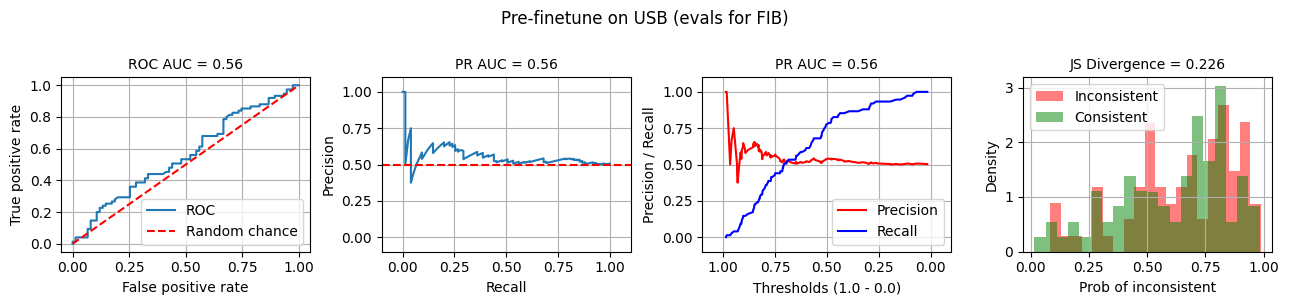

2024-05-11 21:50:39 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 21:50:39 - INFO - Threshold: 0.90 - Recall: 0.15, Precision: 0.61
2024-05-11 21:50:39 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 21:50:39 - INFO - Threshold: 0.80 - Recall: 0.35, Precision: 0.58
2024-05-11 21:50:39 - INFO - Threshold: 0.75 - Recall: 0.44, Precision: 0.57
2024-05-11 21:50:39 - INFO - Threshold: 0.70 - Recall: 0.51, Precision: 0.51
2024-05-11 21:50:39 - INFO - Threshold: 0.65 - Recall: 0.55, Precision: 0.51
2024-05-11 21:50:39 - INFO - Threshold: 0.60 - Recall: 0.61, Precision: 0.52


In [ ]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Pre-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

In [ ]:
# df = pd.DataFrame({'label': fib_val_labels, 'pred_proba': fib_val_preds})
# model_name = 'Pre-finetune (evals for FIB)'

# # Compute ROCAUC metrics
# rocauc = roc_auc_score(df['label'], df['pred_proba'])
# fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
# baseline = np.sum(df['label']) / len(df)

# # Compute PRAUC metrics
# prauc = average_precision_score(df['label'], df['pred_proba'])
# prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

# # Split into consistent and inconsistent for prob distribution
# inconsistent = df[df['label'] == 1].reset_index(drop=True)
# consistent = df[df['label'] == 0].reset_index(drop=True)
# js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

# # Set up plots
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(26, 6), tight_layout=True)
# title_font_size = 15
# fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

# # Plot ROC
# ax0.grid()
# ax0.plot(fpr, tpr, label='ROC')
# ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
# ax0.set_xlabel('False positive rate', fontsize=title_font_size)
# ax0.set_ylabel('True positive rate', fontsize=title_font_size)
# ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
# ax0.legend()

# # Plot PRAUC
# ax1.grid()
# ax1.plot(rec, prec, label='PRAUC')
# ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
# ax1.set_xlabel('Recall', fontsize=title_font_size)
# ax1.set_ylabel('Precision', fontsize=title_font_size)
# ax1.set_xlim((-0.1, 1.1))
# ax1.set_ylim((-0.1, 1.1))
# ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot Precision & Recall
# ax2.grid()
# ax2.plot(thresholds, prec[1:], color='red', label='Precision')
# ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
# ax2.invert_xaxis()
# ax2.set_xlabel('Thresholds (1.0 - 0.0)', fontsize=title_font_size)
# ax2.set_ylabel('Precision / Recall', fontsize=title_font_size)
# ax2.set_xlim((1.1, -0.1))
# ax2.set_ylim((-0.1, 1.1))
# ax2.legend()
# ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot prob distribution
# ax3.grid()
# ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.set_xlabel('Prob of inconsistent', fontsize=title_font_size)
# ax3.set_ylabel('Density', fontsize=title_font_size)
# ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
# ax3.legend()

# plt.show()

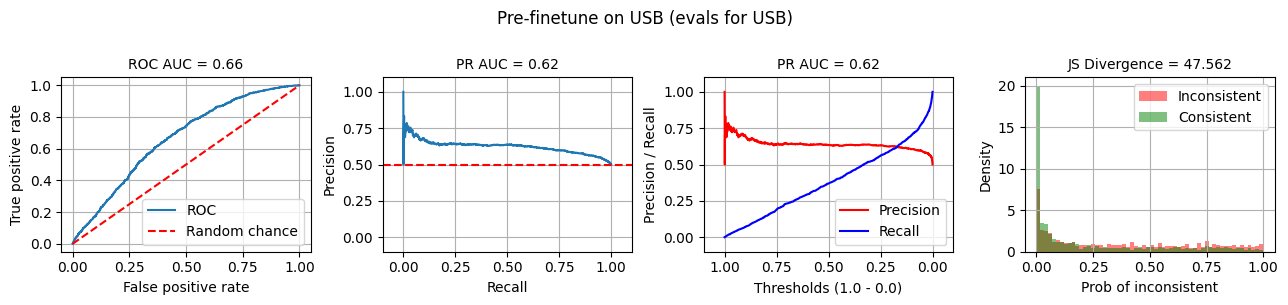

2024-05-11 21:51:28 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.73
2024-05-11 21:51:28 - INFO - Threshold: 0.90 - Recall: 0.07, Precision: 0.69
2024-05-11 21:51:28 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.73
2024-05-11 21:51:28 - INFO - Threshold: 0.80 - Recall: 0.15, Precision: 0.65
2024-05-11 21:51:28 - INFO - Threshold: 0.75 - Recall: 0.19, Precision: 0.64
2024-05-11 21:51:28 - INFO - Threshold: 0.70 - Recall: 0.23, Precision: 0.64
2024-05-11 21:51:28 - INFO - Threshold: 0.65 - Recall: 0.26, Precision: 0.64
2024-05-11 21:51:28 - INFO - Threshold: 0.60 - Recall: 0.30, Precision: 0.64


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Pre-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

## Start finetuning

## # Metrics from finetuning on FIB-only for comparison
```
Step    Training Loss   Fib Loss    Fib Prauc   Fib Rocauc  Fib Recall  Fib Precision
20      1.371500        0.854492    0.579853    0.579467    0.066667    0.714286
40      0.758200        0.713867    0.601021    0.604978    0.040000    0.750000
60      0.683100        0.681152    0.616764    0.632444    0.053333    0.800000
80      0.671600        0.668945    0.640852    0.648089    0.040000    0.750000
100     0.664400        0.662598    0.649766    0.658133    0.040000    0.750000
```

In [ ]:
trainer.train()

2024-05-11 21:52:16 - INFO - Step 0 metrics: {'eval_usb_loss': 1.8544921875, 'eval_usb_prauc': 0.6233581227052458, 'eval_usb_rocauc': 0.6625970185821631, 'eval_usb_recall': 0.14767616191904048, 'eval_usb_precision': 0.6480263157894737}
2024-05-11 21:52:19 - INFO - Step 0 metrics: {'eval_fib_loss': 2.76171875, 'eval_fib_prauc': 0.5611561212032896, 'eval_fib_rocauc': 0.5572444444444445, 'eval_fib_recall': 0.3466666666666667, 'eval_fib_precision': 0.5777777777777777}


Step,Training Loss,Validation Loss,Usb Loss,Usb Prauc,Usb Rocauc,Usb Recall,Usb Precision,Fib Loss,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
40,0.905700,No log,0.657715,0.763996,0.765208,0.155172,0.896104,0.755859,0.561472,0.574044,0.080000,0.500000
80,0.548200,No log,0.469971,0.873856,0.863627,0.411544,0.958115,0.772949,0.550041,0.570044,0.160000,0.480000
120,0.422100,No log,0.409424,0.914258,0.905461,0.602699,0.935972,0.772461,0.570921,0.599289,0.293333,0.578947
160,0.415800,No log,0.414062,0.926247,0.918202,0.554723,0.961039,0.742676,0.603683,0.611022,0.066667,0.833333
200,0.345100,No log,0.374512,0.933913,0.926156,0.637181,0.953984,0.759277,0.604829,0.612178,0.080000,0.750000
240,0.341000,No log,0.354248,0.937137,0.930274,0.689655,0.942623,0.741211,0.618775,0.621511,0.253333,0.760000
280,0.314700,No log,0.349609,0.939855,0.933328,0.688906,0.944502,0.753418,0.633330,0.631911,0.146667,0.733333
320,0.299100,No log,0.339844,0.941927,0.935179,0.724138,0.934236,0.752930,0.636335,0.632622,0.253333,0.760000
360,0.279600,No log,0.353516,0.943060,0.936693,0.733133,0.934990,0.777832,0.649446,0.638756,0.240000,0.720000
400,0.297100,No log,0.339111,0.945611,0.938384,0.718141,0.948515,0.773926,0.628032,0.626844,0.160000,0.666667


Checkpoint destination directory /content/drive/My Drive/Colab Notebooks/usb-only/checkpoint-40 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Checkpoint destination directory /content/drive/My Drive/Colab Notebooks/usb-only/checkpoint-80 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Checkpoint destination directory /content/drive/My Drive/Colab Noteb

## Check evals after finetuning on USB

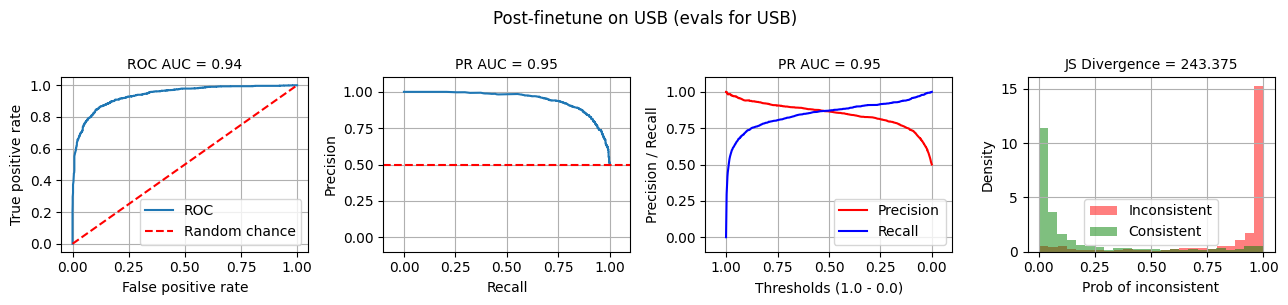

2024-05-11 22:42:54 - INFO - Threshold: 0.95 - Recall: 0.65, Precision: 0.97
2024-05-11 22:42:54 - INFO - Threshold: 0.90 - Recall: 0.73, Precision: 0.94
2024-05-11 22:42:54 - INFO - Threshold: 0.95 - Recall: 0.65, Precision: 0.97
2024-05-11 22:42:54 - INFO - Threshold: 0.80 - Recall: 0.79, Precision: 0.92
2024-05-11 22:42:54 - INFO - Threshold: 0.75 - Recall: 0.81, Precision: 0.91
2024-05-11 22:42:54 - INFO - Threshold: 0.70 - Recall: 0.82, Precision: 0.90
2024-05-11 22:42:54 - INFO - Threshold: 0.65 - Recall: 0.84, Precision: 0.89
2024-05-11 22:42:54 - INFO - Threshold: 0.60 - Recall: 0.85, Precision: 0.88


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

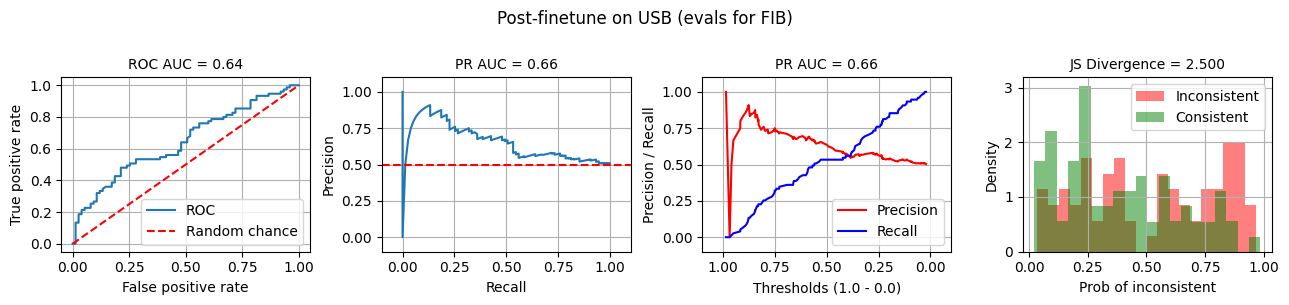

2024-05-11 22:42:57 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 22:42:57 - INFO - Threshold: 0.90 - Recall: 0.08, Precision: 0.86
2024-05-11 22:42:57 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 22:42:57 - INFO - Threshold: 0.80 - Recall: 0.25, Precision: 0.73
2024-05-11 22:42:57 - INFO - Threshold: 0.75 - Recall: 0.32, Precision: 0.73
2024-05-11 22:42:57 - INFO - Threshold: 0.70 - Recall: 0.36, Precision: 0.71
2024-05-11 22:42:57 - INFO - Threshold: 0.65 - Recall: 0.39, Precision: 0.67
2024-05-11 22:42:57 - INFO - Threshold: 0.60 - Recall: 0.44, Precision: 0.67


In [ ]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Post-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

## Next, set up trainer to finetune on FIB data
- FIB contains one-sentence summaries on CNN/DM & XSUM news articles.
- Note: We exclude the CNN/Daily Mail data is pretty bad.
- https://huggingface.co/datasets/r-three/fib

In [ ]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10
EVAL_STEPS=20
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [ ]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='/content/drive/My Drive/Colab Notebooks/usb-fib',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,  # Update eval steps to reduce time spent on evals
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_recall',
    greater_is_better=True,
    load_best_model_at_end=True,
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=fib_ds['train'],
    eval_dataset={'usb': usb_ds['val'], 'fib': fib_ds['val']},  # Custom trainer supports two eval datasets!
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


# # Metrics from finetuning on FIB-only for comparison
```
Step    Training Loss   Fib Loss    Fib Prauc   Fib Rocauc  Fib Recall  Fib Precision
20      1.371500        0.854492    0.579853    0.579467    0.066667    0.714286
40      0.758200        0.713867    0.601021    0.604978    0.040000    0.750000
60      0.683100        0.681152    0.616764    0.632444    0.053333    0.800000
80      0.671600        0.668945    0.640852    0.648089    0.040000    0.750000
100     0.664400        0.662598    0.649766    0.658133    0.040000    0.750000
```

In [ ]:
trainer.train()

2024-05-11 22:43:46 - INFO - Step 0 metrics: {'eval_usb_loss': 0.336669921875, 'eval_usb_prauc': 0.9458174724898825, 'eval_usb_rocauc': 0.9399249026161584, 'eval_usb_recall': 0.7886056971514243, 'eval_usb_precision': 0.9187772925764193}
2024-05-11 22:43:49 - INFO - Step 0 metrics: {'eval_fib_loss': 0.7568359375, 'eval_fib_prauc': 0.6580583088395531, 'eval_fib_rocauc': 0.6432, 'eval_fib_recall': 0.25333333333333335, 'eval_fib_precision': 0.7307692307692307}


Step,Training Loss,Validation Loss,Usb Loss,Usb Prauc,Usb Rocauc,Usb Recall,Usb Precision,Fib Loss,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
20,0.650600,No log,0.503418,0.938988,0.934167,0.894303,0.821625,0.598633,0.740828,0.756800,0.293333,0.880000
40,0.540700,No log,0.544434,0.930835,0.926803,0.902549,0.809684,0.517578,0.819064,0.826844,0.426667,0.914286
60,0.452400,No log,0.502441,0.924939,0.921494,0.865817,0.830338,0.481689,0.857859,0.848356,0.440000,0.942857
80,0.424500,No log,0.519531,0.922597,0.919200,0.868066,0.821277,0.472412,0.868118,0.853067,0.480000,0.923077
100,0.399700,No log,0.563965,0.919798,0.916684,0.876312,0.802334,0.464844,0.874490,0.861689,0.573333,0.934783


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

## Check evals after finetuning on USB followed by FIB

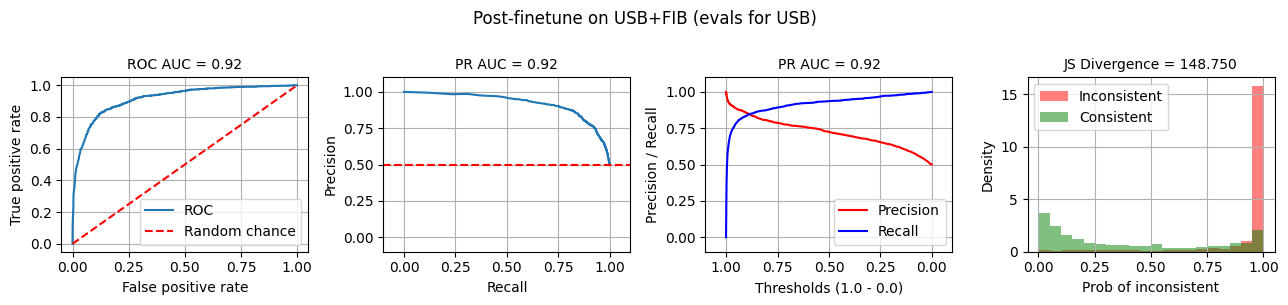

2024-05-11 22:53:38 - INFO - Threshold: 0.95 - Recall: 0.79, Precision: 0.88
2024-05-11 22:53:38 - INFO - Threshold: 0.90 - Recall: 0.84, Precision: 0.85
2024-05-11 22:53:38 - INFO - Threshold: 0.95 - Recall: 0.79, Precision: 0.88
2024-05-11 22:53:38 - INFO - Threshold: 0.80 - Recall: 0.88, Precision: 0.80
2024-05-11 22:53:38 - INFO - Threshold: 0.75 - Recall: 0.89, Precision: 0.79
2024-05-11 22:53:38 - INFO - Threshold: 0.70 - Recall: 0.91, Precision: 0.77
2024-05-11 22:53:38 - INFO - Threshold: 0.65 - Recall: 0.92, Precision: 0.76
2024-05-11 22:53:38 - INFO - Threshold: 0.60 - Recall: 0.92, Precision: 0.75


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB+FIB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

In [ ]:
def eval_fib(dataset, split='val'):
    # Get predictions
    fib_preds = trainer.predict(fib_ds[split])[0]

    # Get labels and update them so entailment = 0 and contradiction = 1
    fib_labels = np.array(fib_ds[split]['label'])
    fib_labels = np.where(fib_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    visualize_preds(fib_labels, fib_preds, f'Post-finetune on USB+FIB training data ({split})')
    compute_metrics_per_threshold(fib_labels, fib_preds)

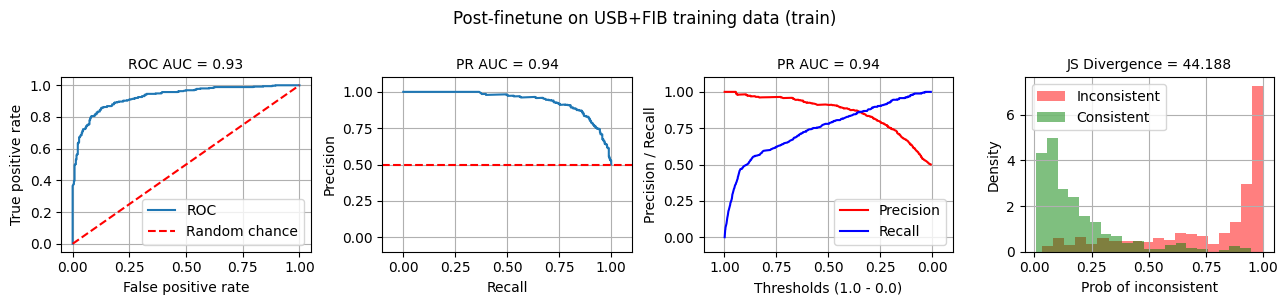

2024-05-11 22:53:52 - INFO - Threshold: 0.95 - Recall: 0.35, Precision: 1.00
2024-05-11 22:53:52 - INFO - Threshold: 0.90 - Recall: 0.49, Precision: 0.98
2024-05-11 22:53:52 - INFO - Threshold: 0.95 - Recall: 0.35, Precision: 1.00
2024-05-11 22:53:52 - INFO - Threshold: 0.80 - Recall: 0.60, Precision: 0.96
2024-05-11 22:53:52 - INFO - Threshold: 0.75 - Recall: 0.63, Precision: 0.96
2024-05-11 22:53:52 - INFO - Threshold: 0.70 - Recall: 0.65, Precision: 0.96
2024-05-11 22:53:52 - INFO - Threshold: 0.65 - Recall: 0.70, Precision: 0.95
2024-05-11 22:53:52 - INFO - Threshold: 0.60 - Recall: 0.74, Precision: 0.92


In [ ]:
eval_fib(fib_ds, 'train')

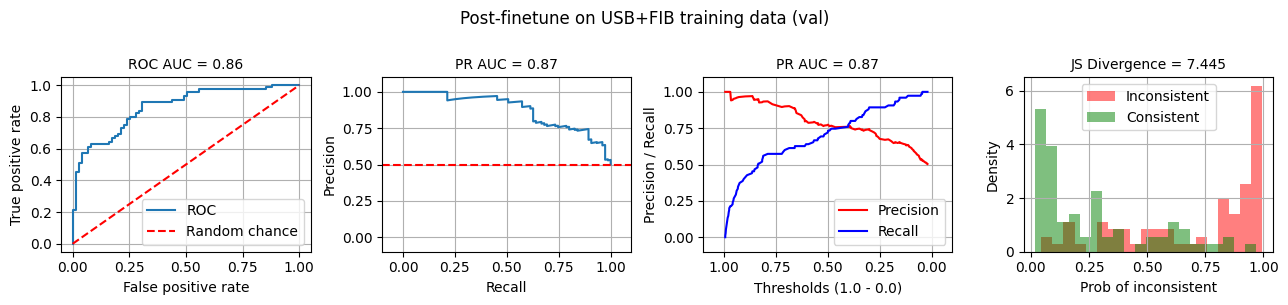

2024-05-11 22:53:56 - INFO - Threshold: 0.95 - Recall: 0.29, Precision: 0.96
2024-05-11 22:53:56 - INFO - Threshold: 0.90 - Recall: 0.41, Precision: 0.97
2024-05-11 22:53:56 - INFO - Threshold: 0.95 - Recall: 0.29, Precision: 0.96
2024-05-11 22:53:56 - INFO - Threshold: 0.80 - Recall: 0.57, Precision: 0.93
2024-05-11 22:53:56 - INFO - Threshold: 0.75 - Recall: 0.57, Precision: 0.90
2024-05-11 22:53:56 - INFO - Threshold: 0.70 - Recall: 0.61, Precision: 0.90
2024-05-11 22:53:56 - INFO - Threshold: 0.65 - Recall: 0.63, Precision: 0.84
2024-05-11 22:53:56 - INFO - Threshold: 0.60 - Recall: 0.64, Precision: 0.79


In [ ]:
eval_fib(fib_ds, 'val')

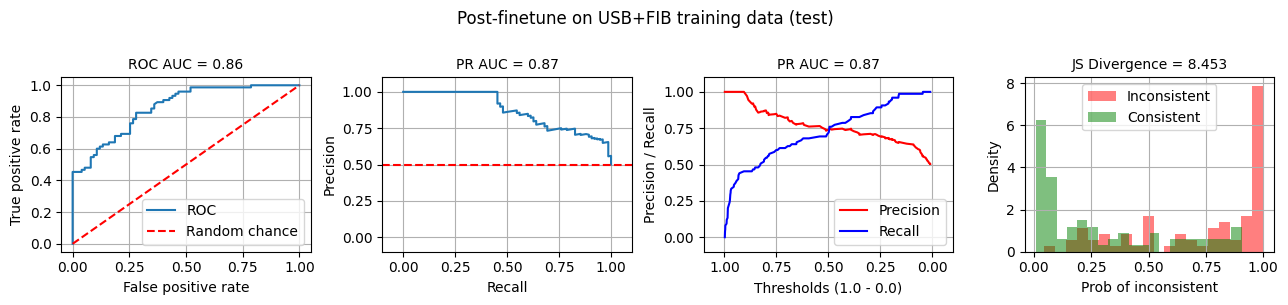

2024-05-11 22:53:59 - INFO - Threshold: 0.95 - Recall: 0.37, Precision: 1.00
2024-05-11 22:53:59 - INFO - Threshold: 0.90 - Recall: 0.45, Precision: 0.97
2024-05-11 22:53:59 - INFO - Threshold: 0.95 - Recall: 0.37, Precision: 1.00
2024-05-11 22:53:59 - INFO - Threshold: 0.80 - Recall: 0.55, Precision: 0.85
2024-05-11 22:53:59 - INFO - Threshold: 0.75 - Recall: 0.60, Precision: 0.83
2024-05-11 22:53:59 - INFO - Threshold: 0.70 - Recall: 0.63, Precision: 0.82
2024-05-11 22:53:59 - INFO - Threshold: 0.65 - Recall: 0.67, Precision: 0.78
2024-05-11 22:53:59 - INFO - Threshold: 0.60 - Recall: 0.68, Precision: 0.76


In [ ]:
eval_fib(fib_ds, 'test')

In [ ]:
# df = pd.DataFrame({'label': fib_val_labels, 'pred_proba': fib_val_preds})
# model_name = 'Post-finetune on USB+FIB (evals for FIB)'

# # Compute ROCAUC metrics
# rocauc = roc_auc_score(df['label'], df['pred_proba'])
# fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
# baseline = np.sum(df['label']) / len(df)

# # Compute PRAUC metrics
# prauc = average_precision_score(df['label'], df['pred_proba'])
# prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

# # Split into consistent and inconsistent for prob distribution
# inconsistent = df[df['label'] == 1].reset_index(drop=True)
# consistent = df[df['label'] == 0].reset_index(drop=True)
# js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

# # Set up plots
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(26, 6), tight_layout=True)
# title_font_size = 15
# fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

# # Plot ROC
# ax0.grid()
# ax0.plot(fpr, tpr, label='ROC')
# ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
# ax0.set_xlabel('False positive rate', fontsize=title_font_size)
# ax0.set_ylabel('True positive rate', fontsize=title_font_size)
# ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
# ax0.legend()

# # Plot PRAUC
# ax1.grid()
# ax1.plot(rec, prec, label='PRAUC')
# ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
# ax1.set_xlabel('Recall', fontsize=title_font_size)
# ax1.set_ylabel('Precision', fontsize=title_font_size)
# ax1.set_xlim((-0.1, 1.1))
# ax1.set_ylim((-0.1, 1.1))
# ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot Precision & Recall
# ax2.grid()
# ax2.plot(thresholds, prec[1:], color='red', label='Precision')
# ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
# ax2.invert_xaxis()
# ax2.set_xlabel('Thresholds (1.0 - 0.0)', fontsize=title_font_size)
# ax2.set_ylabel('Precision / Recall', fontsize=title_font_size)
# ax2.set_xlim((1.1, -0.1))
# ax2.set_ylim((-0.1, 1.1))
# ax2.legend()
# ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot prob distribution
# ax3.grid()
# ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.set_xlabel('Prob of inconsistent', fontsize=title_font_size)
# ax3.set_ylabel('Density', fontsize=title_font_size)
# ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
# ax3.legend()

# plt.show()